In [33]:
import os
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [34]:
# Configuration
EXPERIMENT_NAME = 'viridian-lizard'  # Change this to your experiment name
BASE_DIR = Path(r'C:\Users\AviGoyal\Documents\LightingStudio\tmp\experiments')
MIN_COMPONENT_SIZE = 100 # Minimum size for connected components in pixels

# Get experiment directory
experiment_dir = BASE_DIR / EXPERIMENT_NAME
if not experiment_dir.exists():
    raise ValueError(f"Experiment directory not found: {experiment_dir}")

print(f"Processing experiment: {EXPERIMENT_NAME}")
print(f"Directory: {experiment_dir}")

Processing experiment: viridian-lizard
Directory: C:\Users\AviGoyal\Documents\LightingStudio\tmp\experiments\viridian-lizard


In [37]:
def merge_wraparound_components(labels, num_labels, binary_img):
    """Merge components that wrap around the equirectangular image edges."""
    height, width = labels.shape
    
    # Find components that touch the left and right edges
    left_edge_labels = set(labels[:, 0]) - {0}  # Exclude background
    right_edge_labels = set(labels[:, -1]) - {0}
    
    # Create a mapping for label merging
    label_map = {i: i for i in range(num_labels)}
    
    # For each component on the left edge, check if it connects to the right edge
    for left_label in left_edge_labels:
        # Get pixels of this component on the left edge
        left_pixels = np.where((labels[:, 0] == left_label) & (binary_img[:, 0] > 0))[0]
        
        if len(left_pixels) > 0:
            # Check corresponding pixels on the right edge
            for y in left_pixels:
                # Check if there's a component on the right edge at the same height
                if binary_img[y, -1] > 0 and labels[y, -1] != 0:
                    right_label = labels[y, -1]
                    if right_label != left_label and right_label in right_edge_labels:
                        # Merge these components - map the higher label to the lower one
                        min_label = min(left_label, right_label)
                        max_label = max(left_label, right_label)
                        label_map[max_label] = min_label
    
    # Apply transitive closure to handle chains of merges
    for i in range(num_labels):
        root = i
        while label_map[root] != root:
            root = label_map[root]
        label_map[i] = root
    
    # Create new labels with merged components
    merged_labels = np.zeros_like(labels)
    new_label_count = 1
    new_label_map = {0: 0}  # Background stays 0
    
    for old_label in range(1, num_labels):
        merged_label = label_map[old_label]
        if merged_label not in new_label_map:
            new_label_map[merged_label] = new_label_count
            new_label_count += 1
        merged_labels[labels == old_label] = new_label_map[merged_label]
    
    return merged_labels, new_label_count - 1

def filter_components_by_size(labels, num_labels, min_size, binary_img):
    """Filter out components smaller than min_size pixels."""
    # Get component stats using the merged labels
    stats = cv2.connectedComponentsWithStats(binary_img)[2]
    
    # Count actual pixels for each label in the merged image
    label_sizes = {}
    for label in range(1, num_labels + 1):
        label_sizes[label] = np.sum(labels == label)
    
    # Create filtered labels image
    filtered_labels = np.zeros_like(labels)
    new_label = 1
    
    # Skip background (label 0)
    for label in range(1, num_labels + 1):
        # Check if component is large enough
        if label in label_sizes and label_sizes[label] >= min_size:
            filtered_labels[labels == label] = new_label
            new_label += 1
    
    return filtered_labels, new_label - 1

def create_labeled_image(labels):
    """Create a color-coded visualization of labeled components."""
    if np.max(labels) > 0:
        label_hue = np.uint8(179*labels/np.max(labels))
    else:
        label_hue = np.zeros_like(labels, dtype=np.uint8)
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue==0] = 0
    return labeled_img

def process_and_display_hdri(hdri_name, hdri_dir):
    """Process a single HDRI's density map and display results."""
    density_map_path = hdri_dir / 'web' / f'{hdri_name}_density_map_fast.png'
    original_hdri_path = hdri_dir / 'web' / f'{hdri_name}_original.png'
    
    if not density_map_path.exists():
        print(f"Warning: Density map not found for {hdri_name}")
        return None
    
    # Read the original HDRI image
    hdri_img = None
    if original_hdri_path.exists():
        hdri_img = cv2.imread(str(original_hdri_path))
        if hdri_img is not None:
            hdri_img = cv2.cvtColor(hdri_img, cv2.COLOR_BGR2RGB)
    
    # Read and process the density map
    img = cv2.imread(str(density_map_path))
    if img is None:
        print(f"Error: Could not read {density_map_path}")
        return None
        
    density_img = img.copy()
    
    # Convert to binary for connected components
    img_binary = cv2.threshold(img, 115, 255, cv2.THRESH_BINARY)[1]
    img_gray = cv2.cvtColor(img_binary, cv2.COLOR_BGR2GRAY)
    num_labels_original, labels_original = cv2.connectedComponents(img_gray)
    
    # Merge components that wrap around the image edges
    labels_merged, num_labels_merged = merge_wraparound_components(
        labels_original, num_labels_original, img_gray
    )
    
    # Filter components by size
    filtered_labels, num_filtered = filter_components_by_size(
        labels_merged, num_labels_merged, MIN_COMPONENT_SIZE, img_gray
    )
    
    # Create labeled images
    labeled_all = create_labeled_image(labels_merged)
    labeled_filtered = create_labeled_image(filtered_labels)
    
    # Convert BGR to RGB for matplotlib
    density_rgb = cv2.cvtColor(density_img, cv2.COLOR_BGR2RGB)
    labeled_all_rgb = cv2.cvtColor(labeled_all, cv2.COLOR_BGR2RGB)
    labeled_filtered_rgb = cv2.cvtColor(labeled_filtered, cv2.COLOR_BGR2RGB)
    
    # Create figure with 4 subplots (2x2 layout)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"{hdri_name}", fontsize=18, fontweight='bold')
    
    # Display original HDRI if available
    if hdri_img is not None:
        ax1.imshow(hdri_img)
        ax1.set_title('Original HDRI', fontsize=14)
    else:
        ax1.text(0.5, 0.5, 'Original HDRI not found', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Original HDRI', fontsize=14)
    ax1.axis('off')
    
    # Display density map
    ax2.imshow(density_rgb)
    ax2.set_title('Density Map', fontsize=14)
    ax2.axis('off')
    
    # Display all components
    ax3.imshow(labeled_all_rgb)
    ax3.set_title(f"All Components (Count: {num_labels_merged})", fontsize=14)
    ax3.axis('off')
    
    # Display filtered components
    ax4.imshow(labeled_filtered_rgb)
    ax4.set_title(f"Filtered (≥{MIN_COMPONENT_SIZE}px, Count: {num_filtered})", fontsize=14)
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"{hdri_name}:")
    print(f"  Original components (before wraparound merge): {num_labels_original-1}")
    print(f"  Components after wraparound merge: {num_labels_merged}")
    print(f"  Filtered components: {num_filtered}")
    print(f"  Components removed by filtering: {num_labels_merged-num_filtered}")
    print()


Found 14 HDRI directories to process:\n


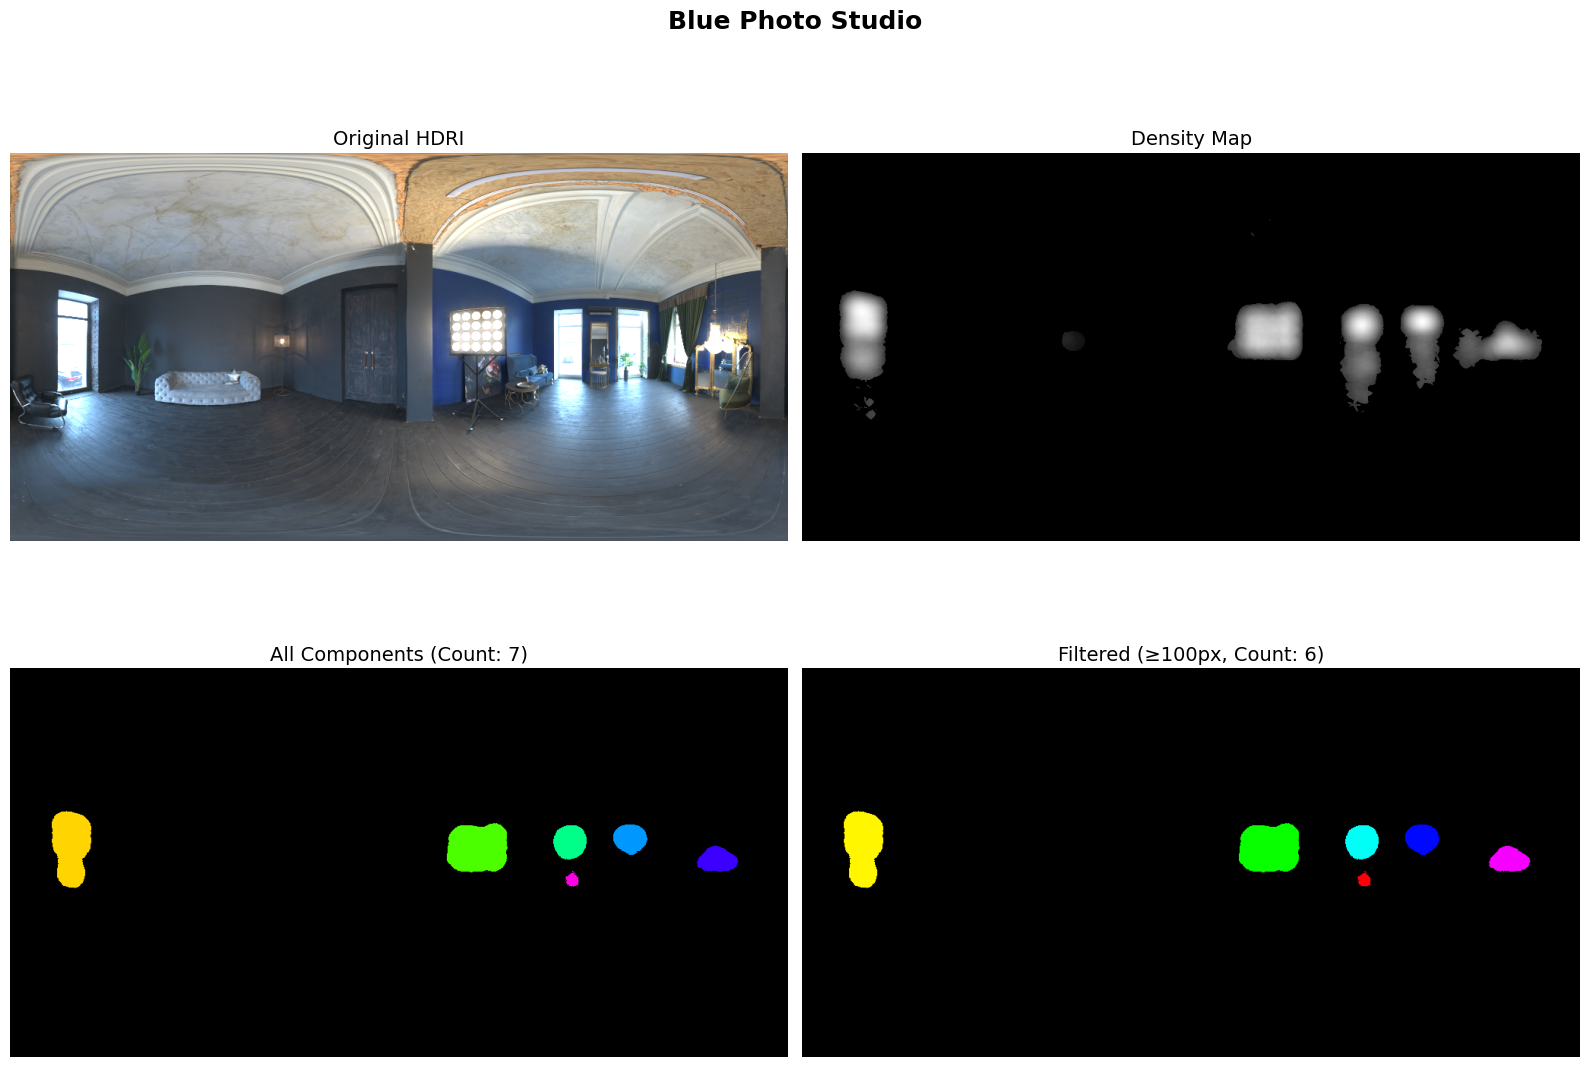

Blue Photo Studio:
  Original components (before wraparound merge): 7
  Components after wraparound merge: 7
  Filtered components: 6
  Components removed by filtering: 1



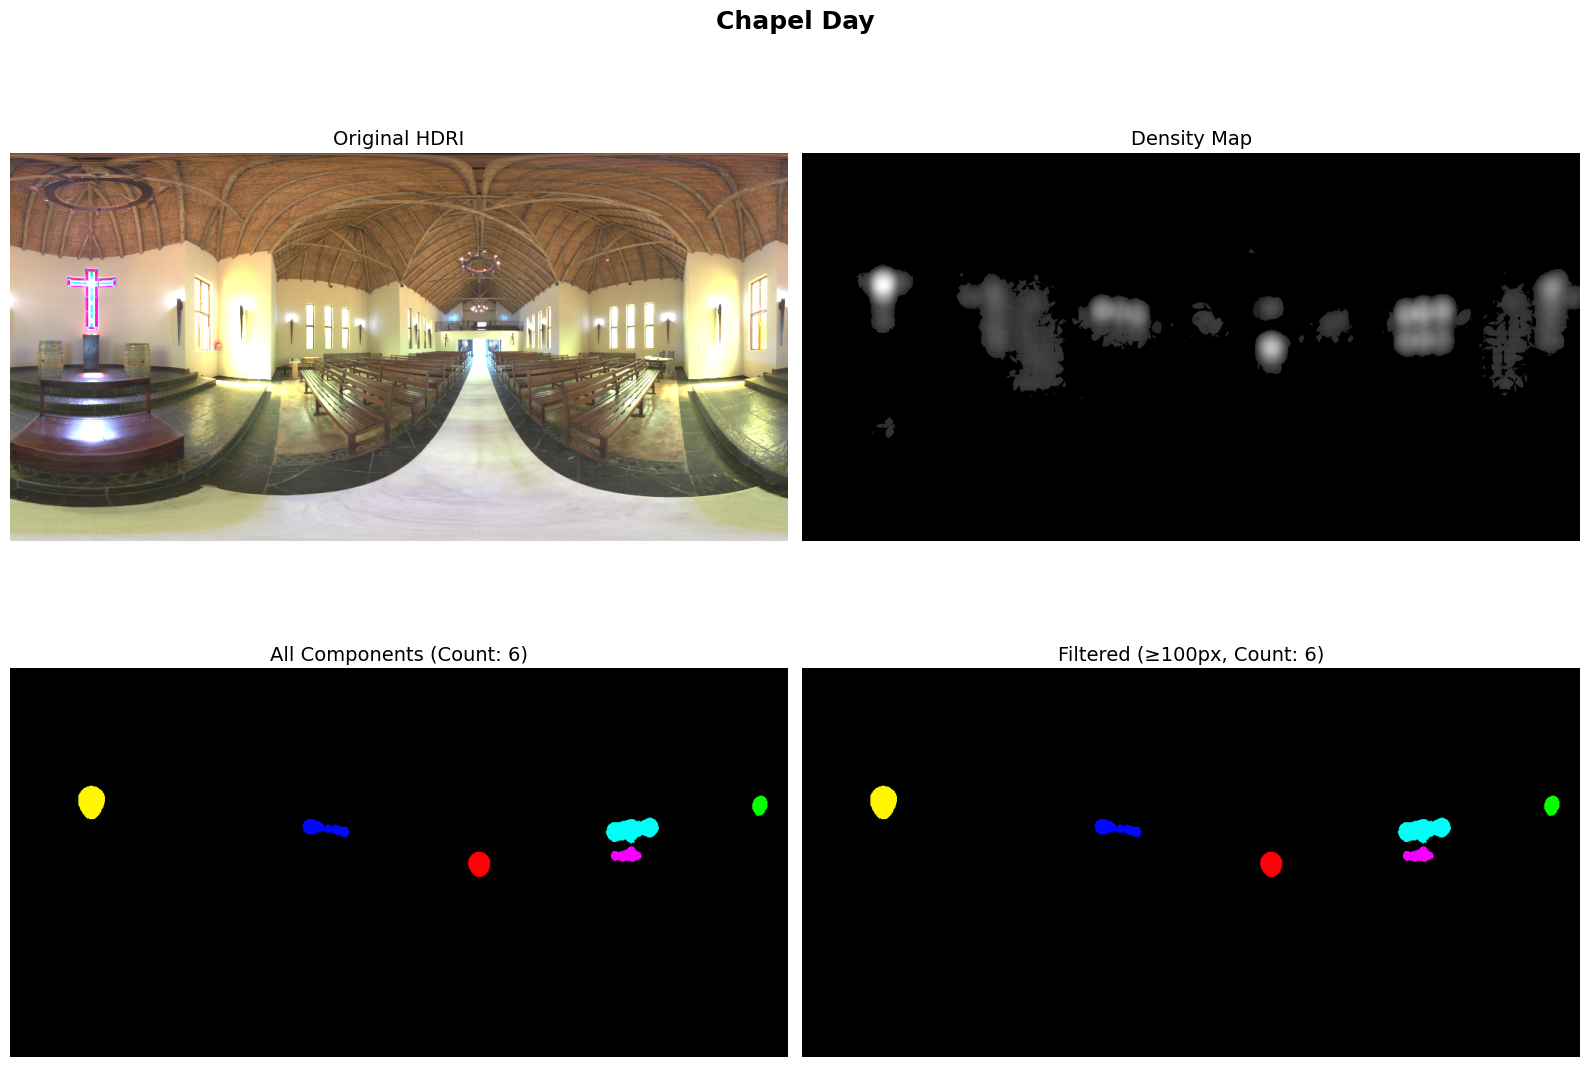

Chapel Day:
  Original components (before wraparound merge): 6
  Components after wraparound merge: 6
  Filtered components: 6
  Components removed by filtering: 0



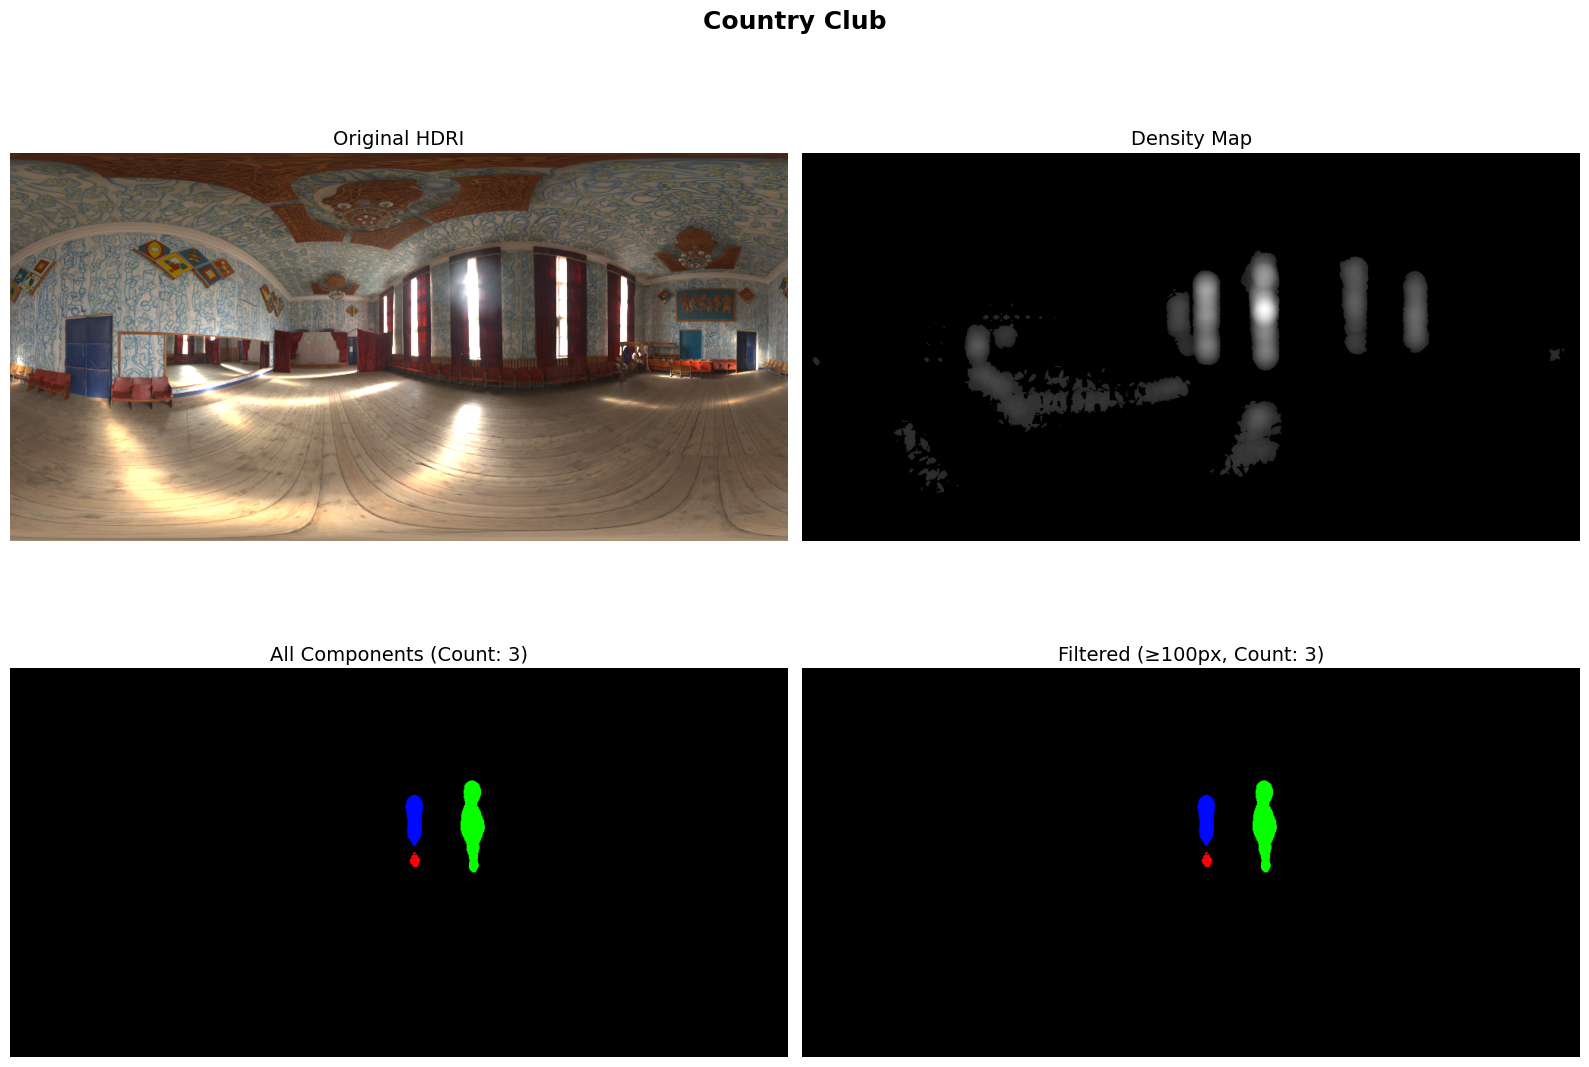

Country Club:
  Original components (before wraparound merge): 3
  Components after wraparound merge: 3
  Filtered components: 3
  Components removed by filtering: 0



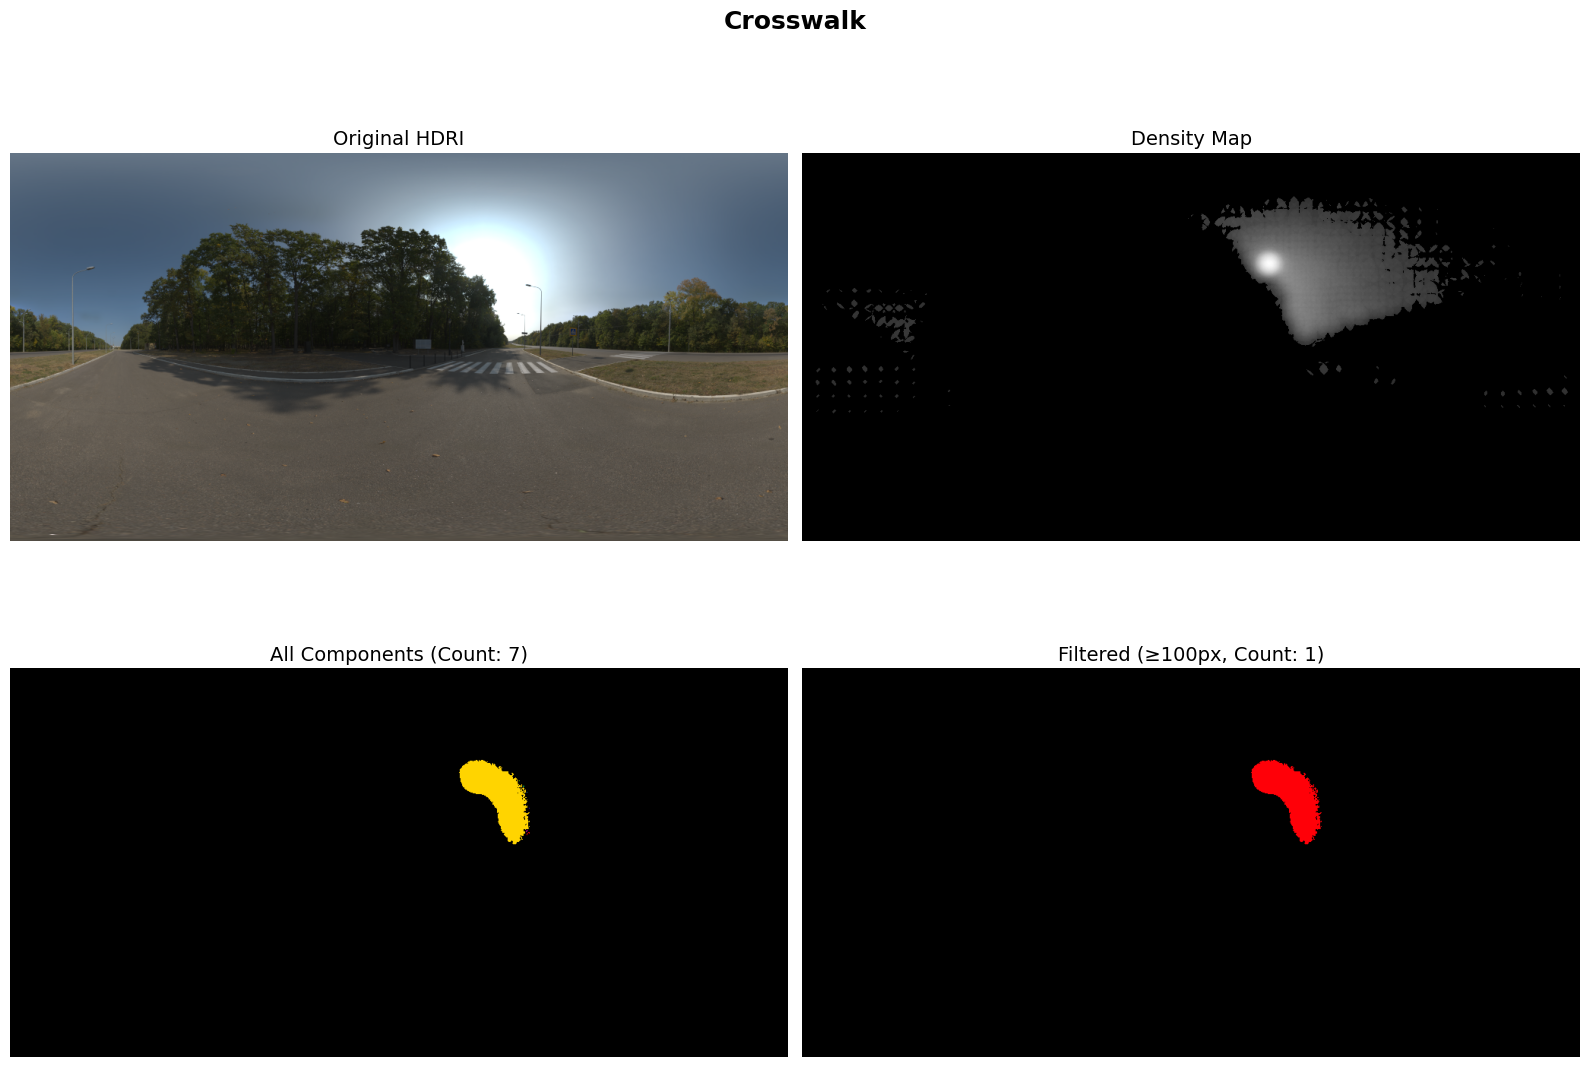

Crosswalk:
  Original components (before wraparound merge): 7
  Components after wraparound merge: 7
  Filtered components: 1
  Components removed by filtering: 6



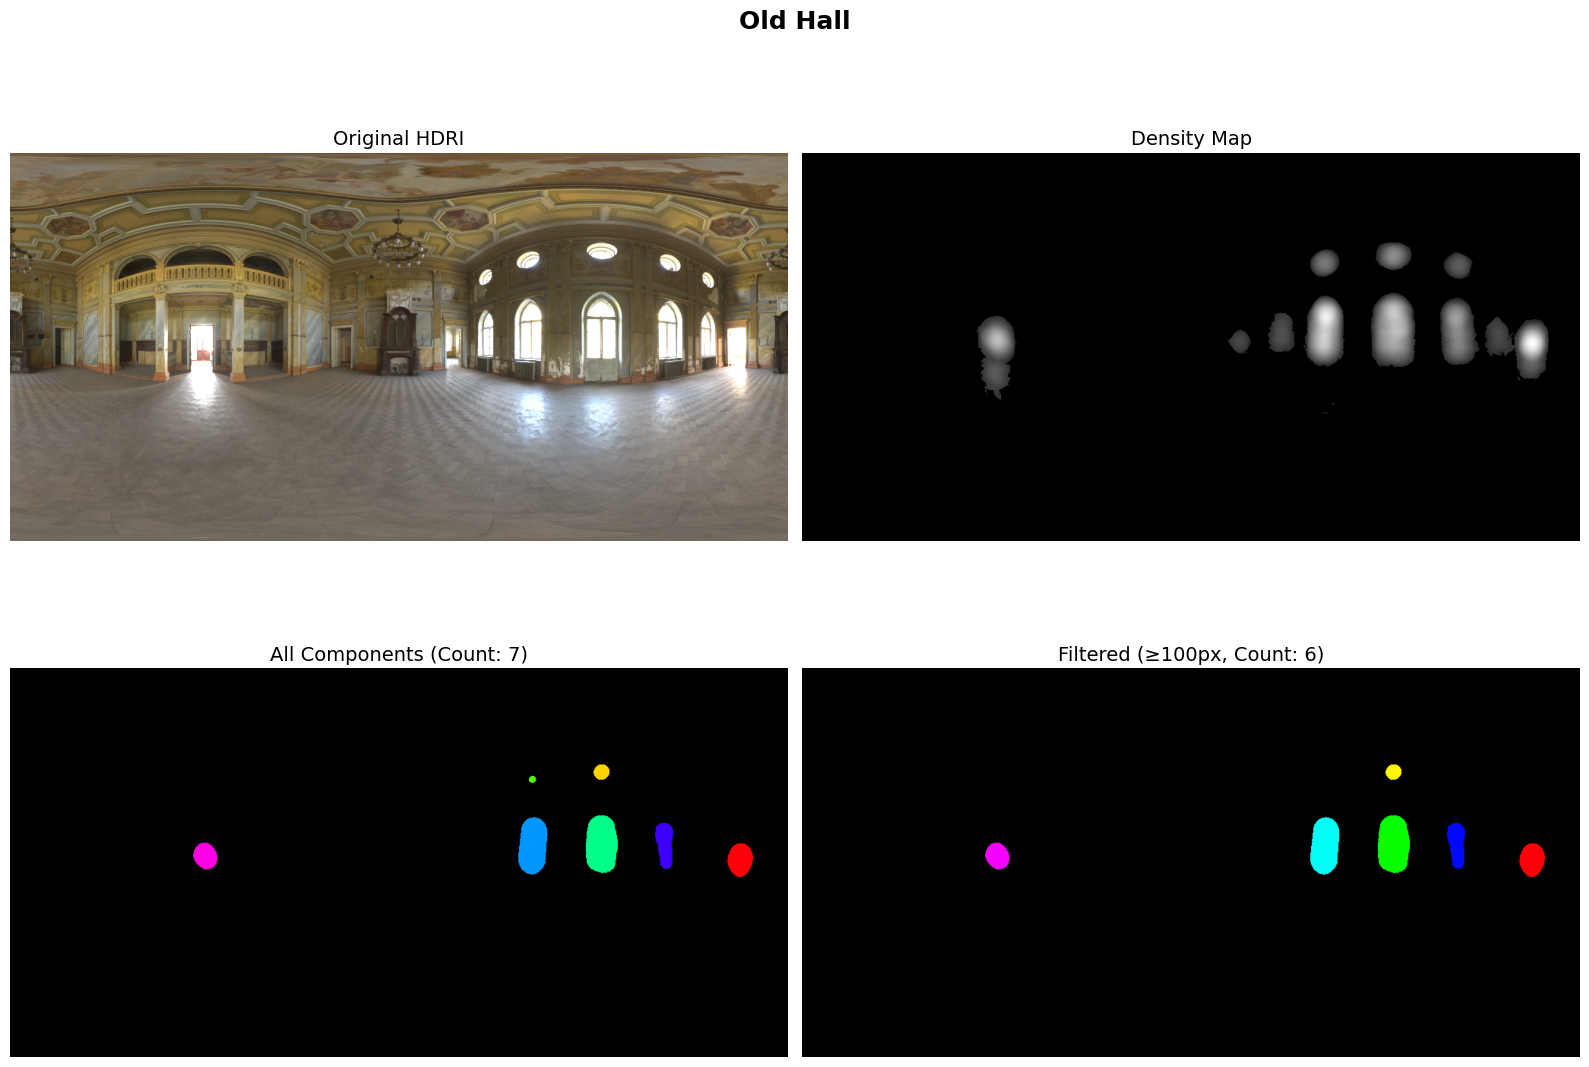

Old Hall:
  Original components (before wraparound merge): 7
  Components after wraparound merge: 7
  Filtered components: 6
  Components removed by filtering: 1



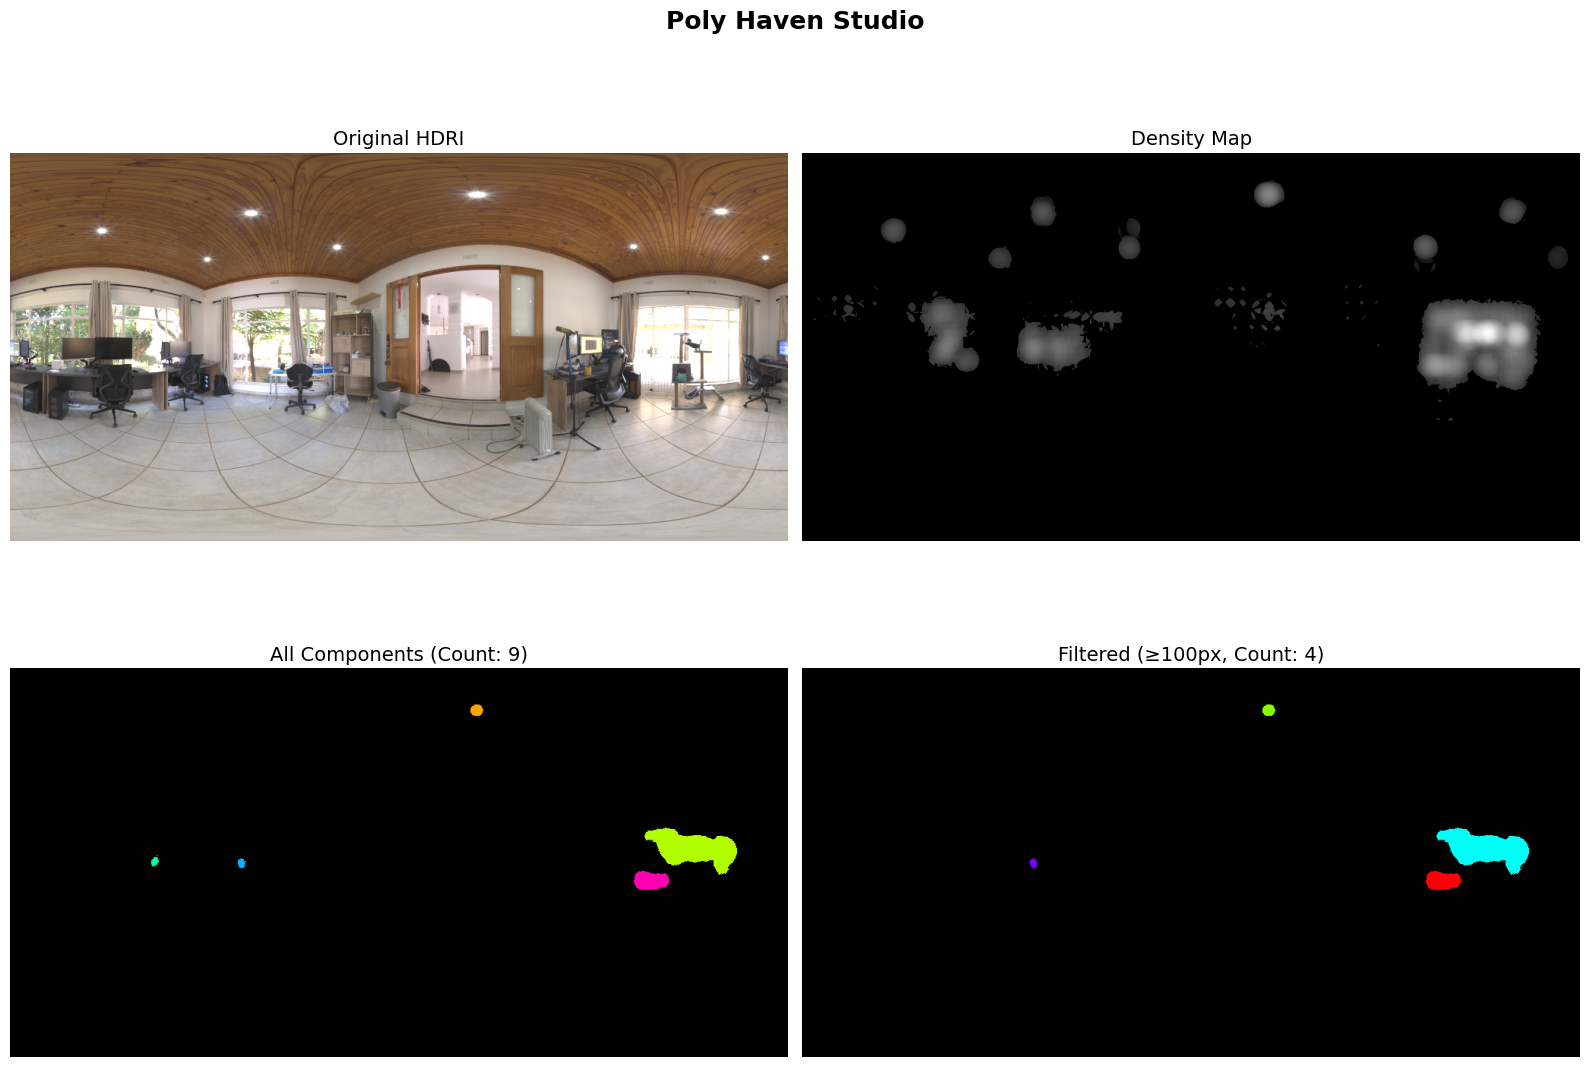

Poly Haven Studio:
  Original components (before wraparound merge): 9
  Components after wraparound merge: 9
  Filtered components: 4
  Components removed by filtering: 5



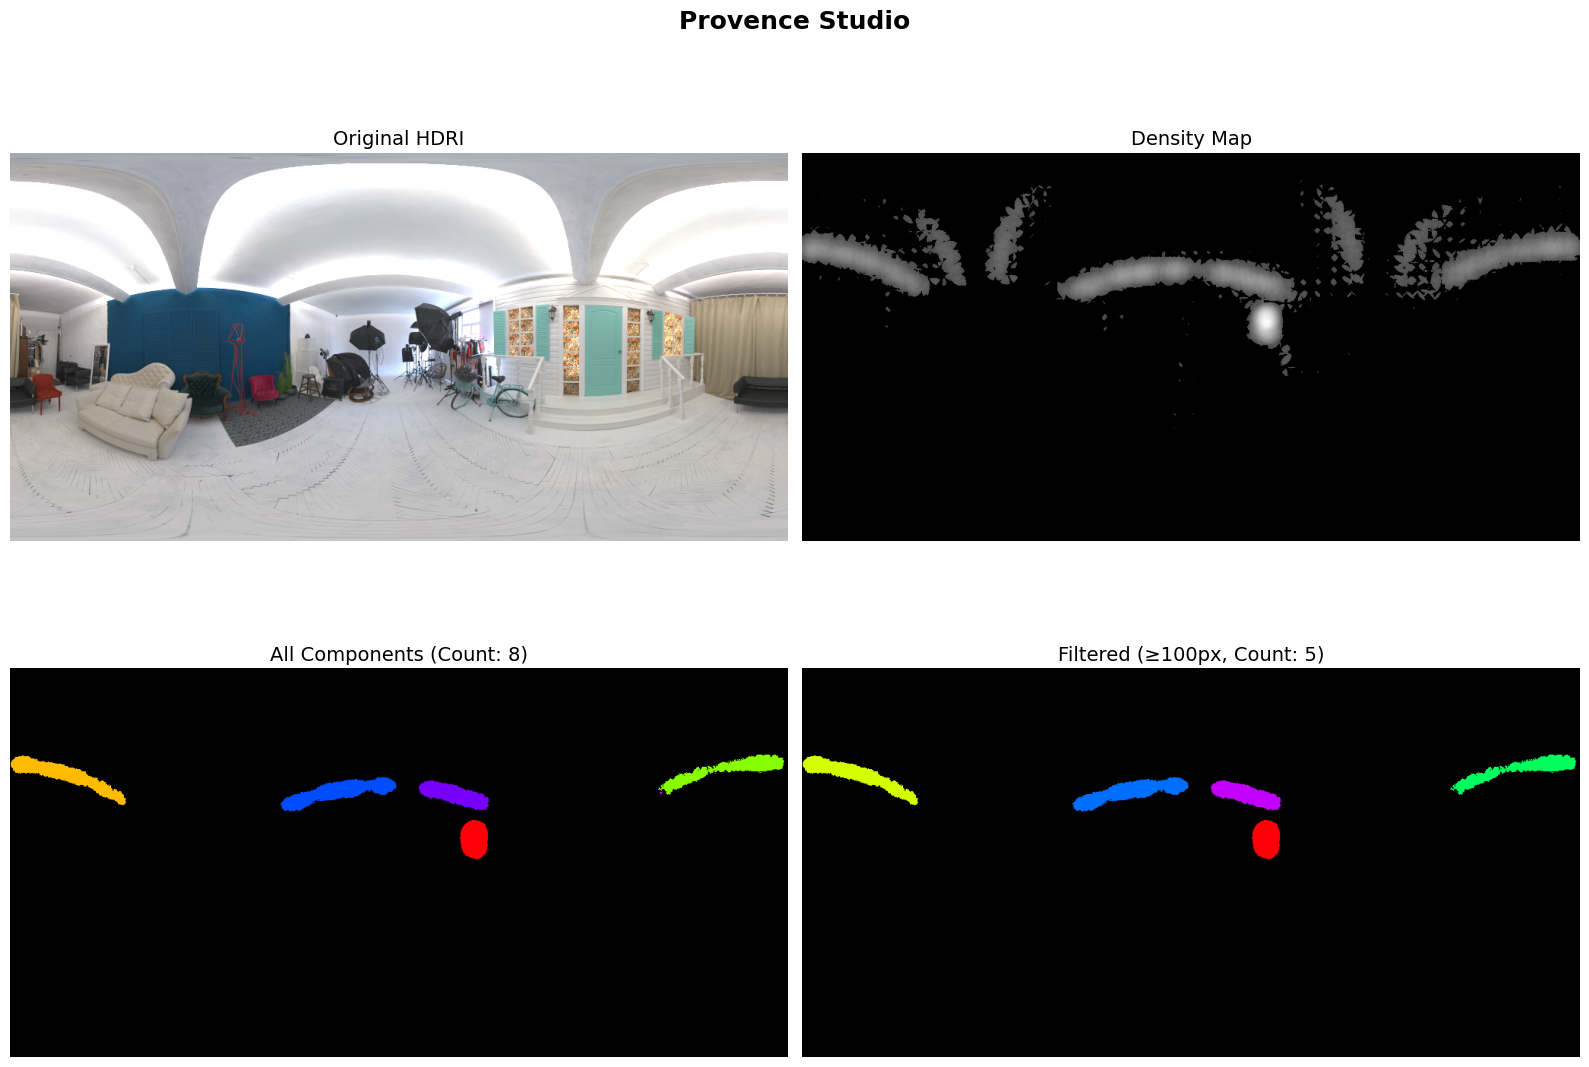

Provence Studio:
  Original components (before wraparound merge): 8
  Components after wraparound merge: 8
  Filtered components: 5
  Components removed by filtering: 3



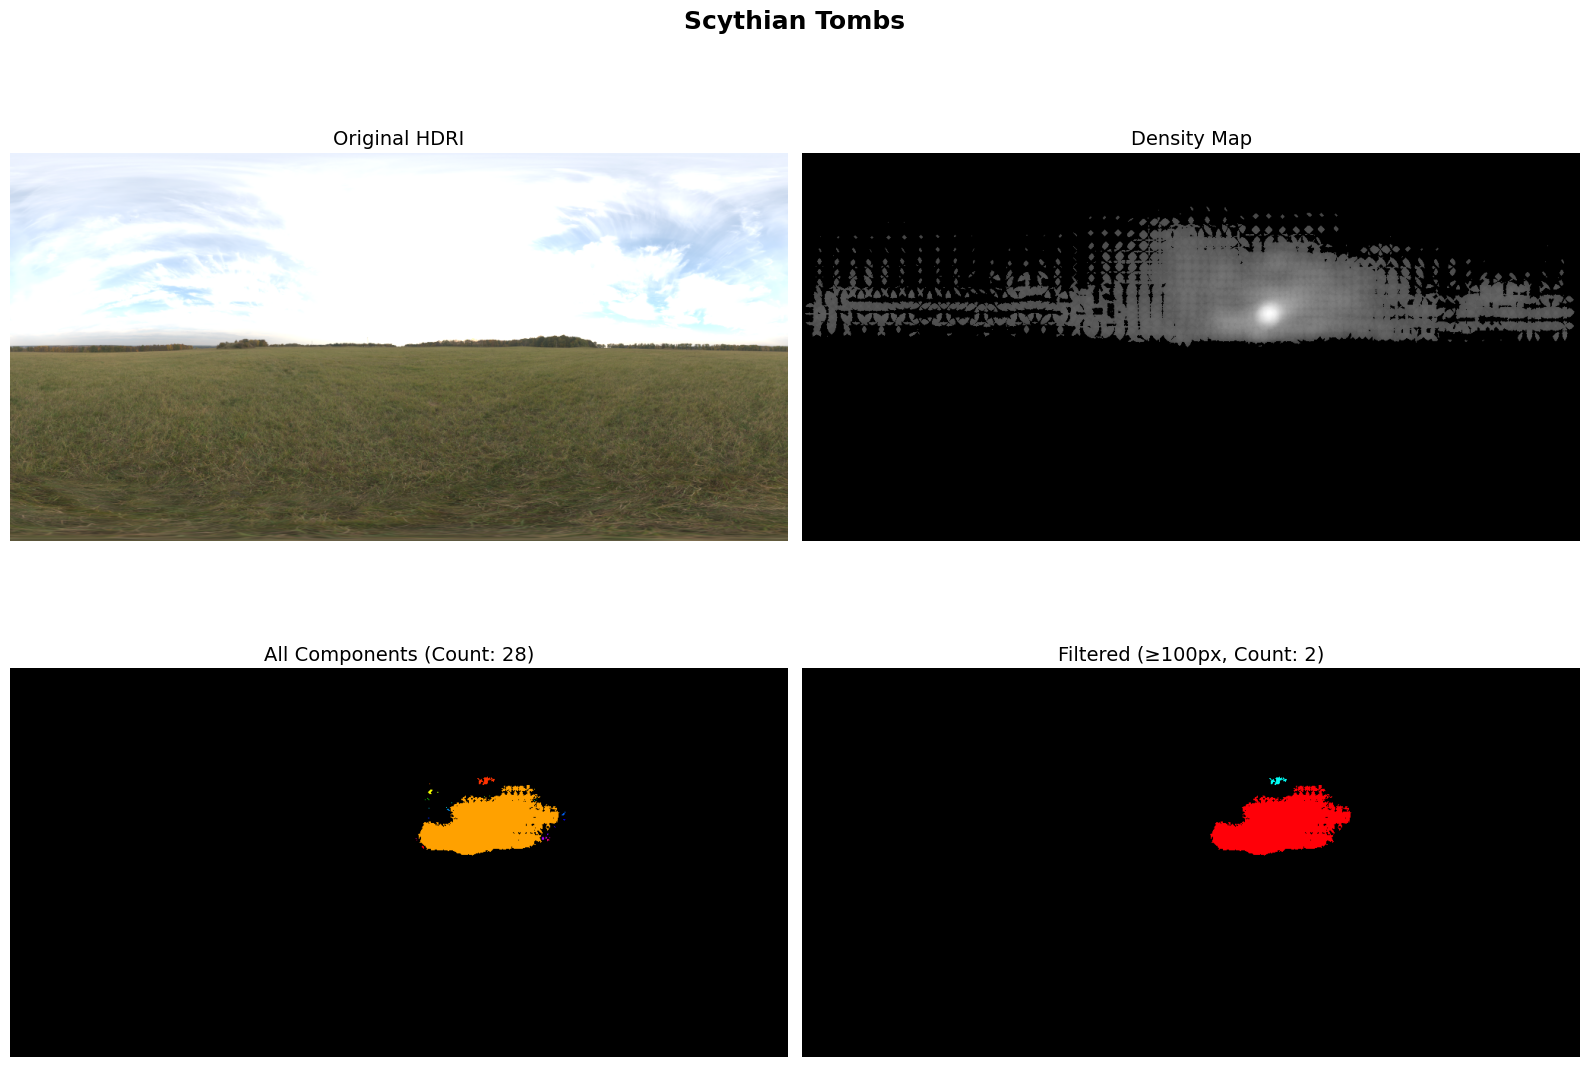

Scythian Tombs:
  Original components (before wraparound merge): 28
  Components after wraparound merge: 28
  Filtered components: 2
  Components removed by filtering: 26



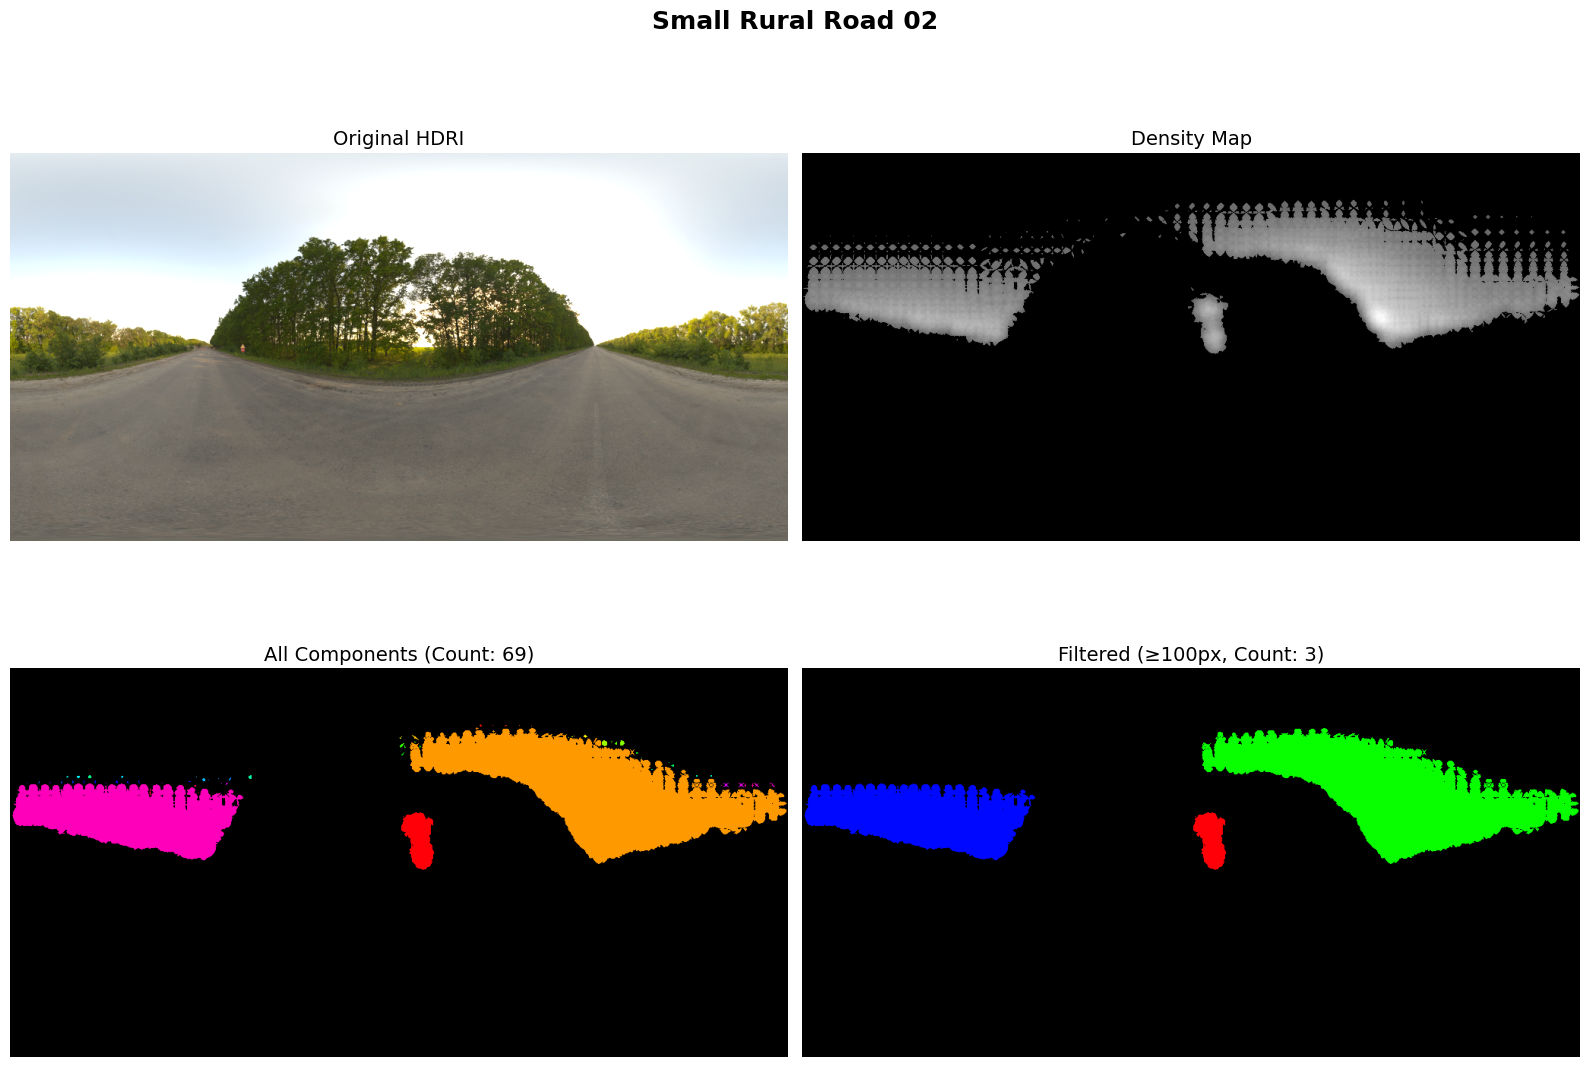

Small Rural Road 02:
  Original components (before wraparound merge): 69
  Components after wraparound merge: 69
  Filtered components: 3
  Components removed by filtering: 66



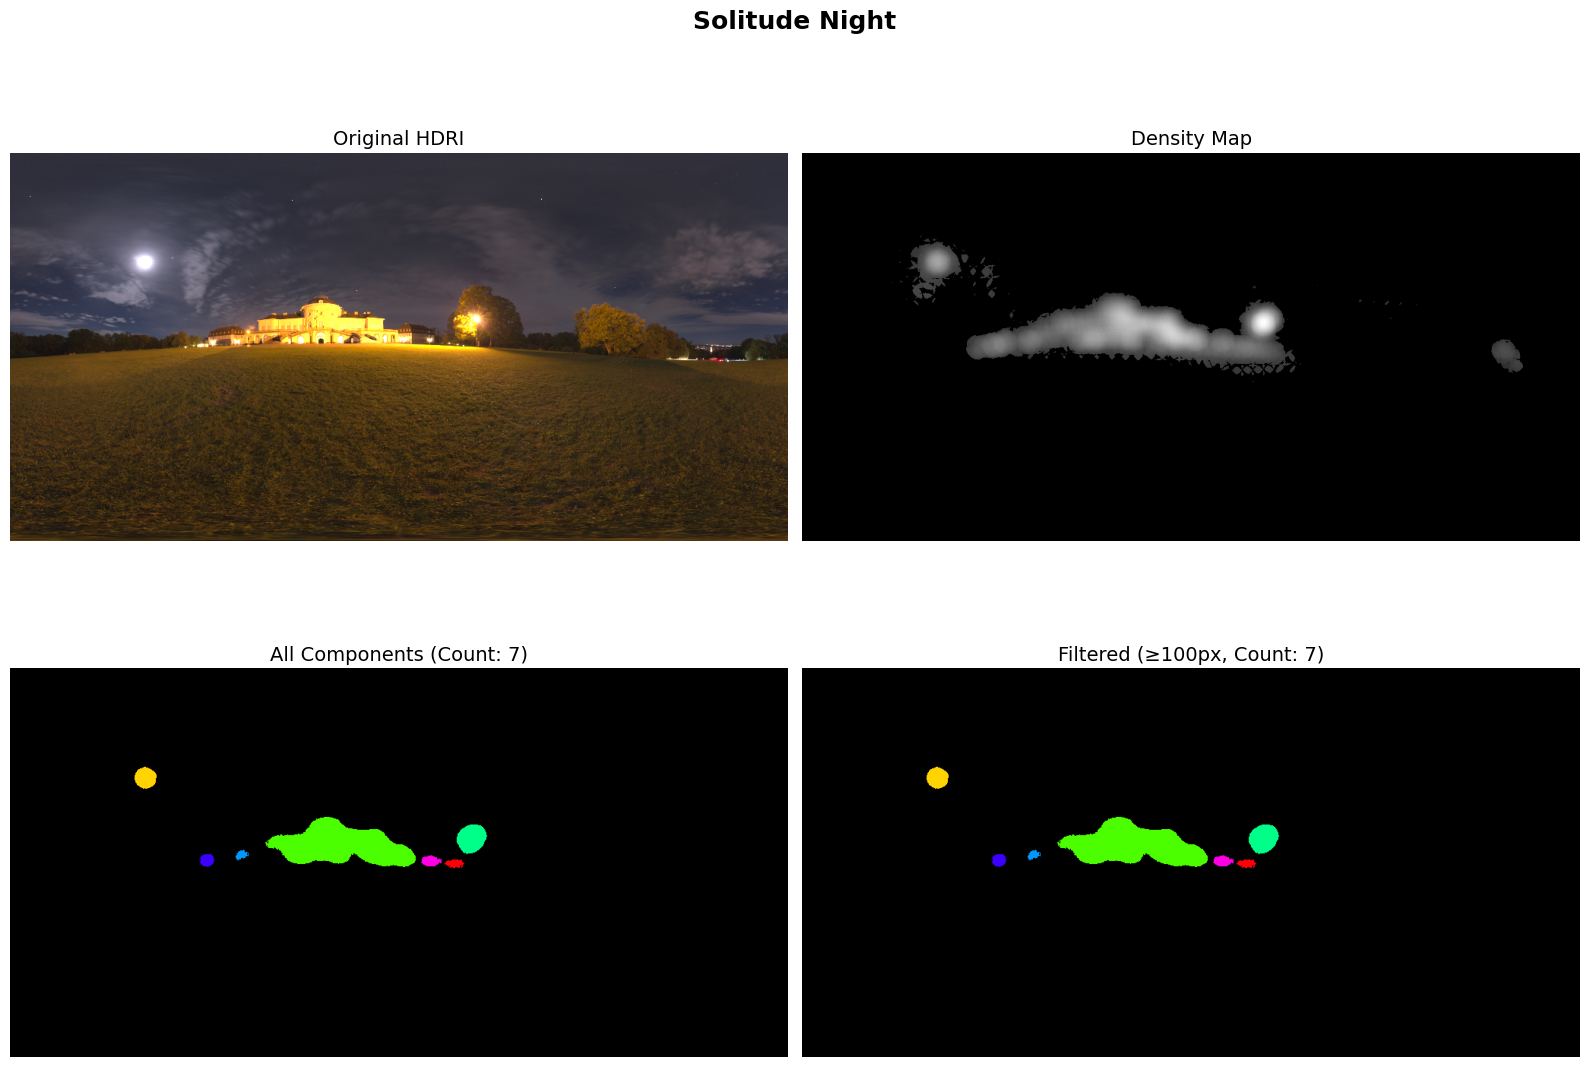

Solitude Night:
  Original components (before wraparound merge): 7
  Components after wraparound merge: 7
  Filtered components: 7
  Components removed by filtering: 0



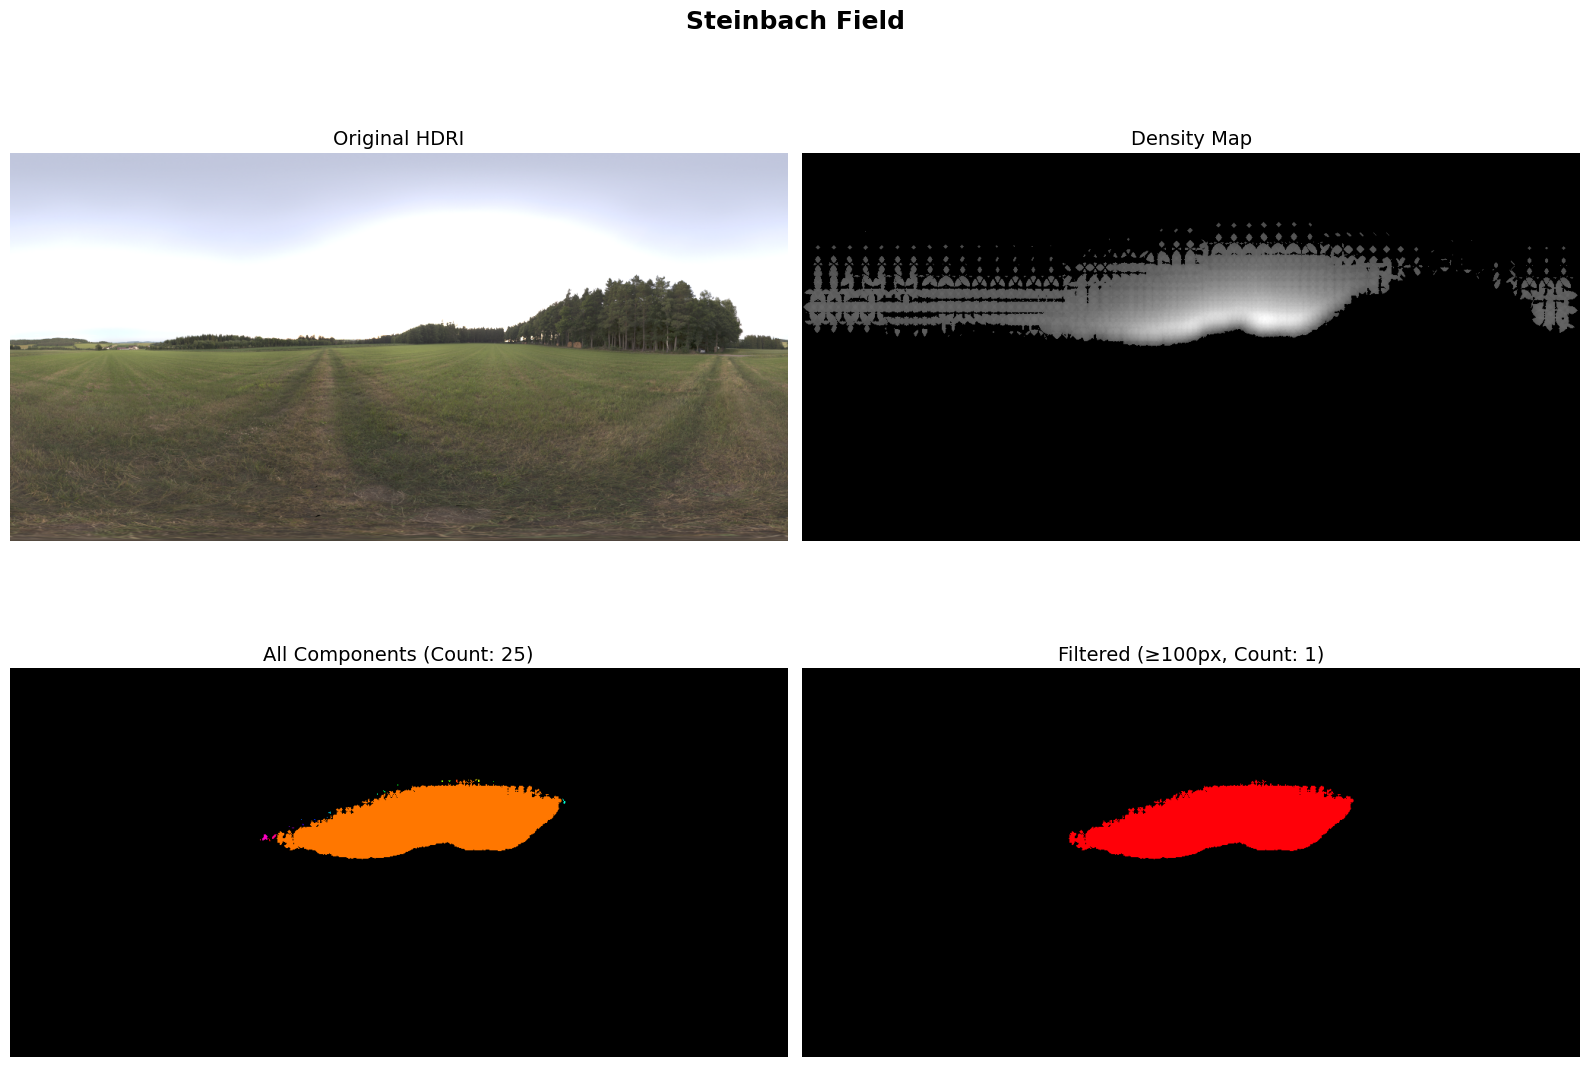

Steinbach Field:
  Original components (before wraparound merge): 25
  Components after wraparound merge: 25
  Filtered components: 1
  Components removed by filtering: 24



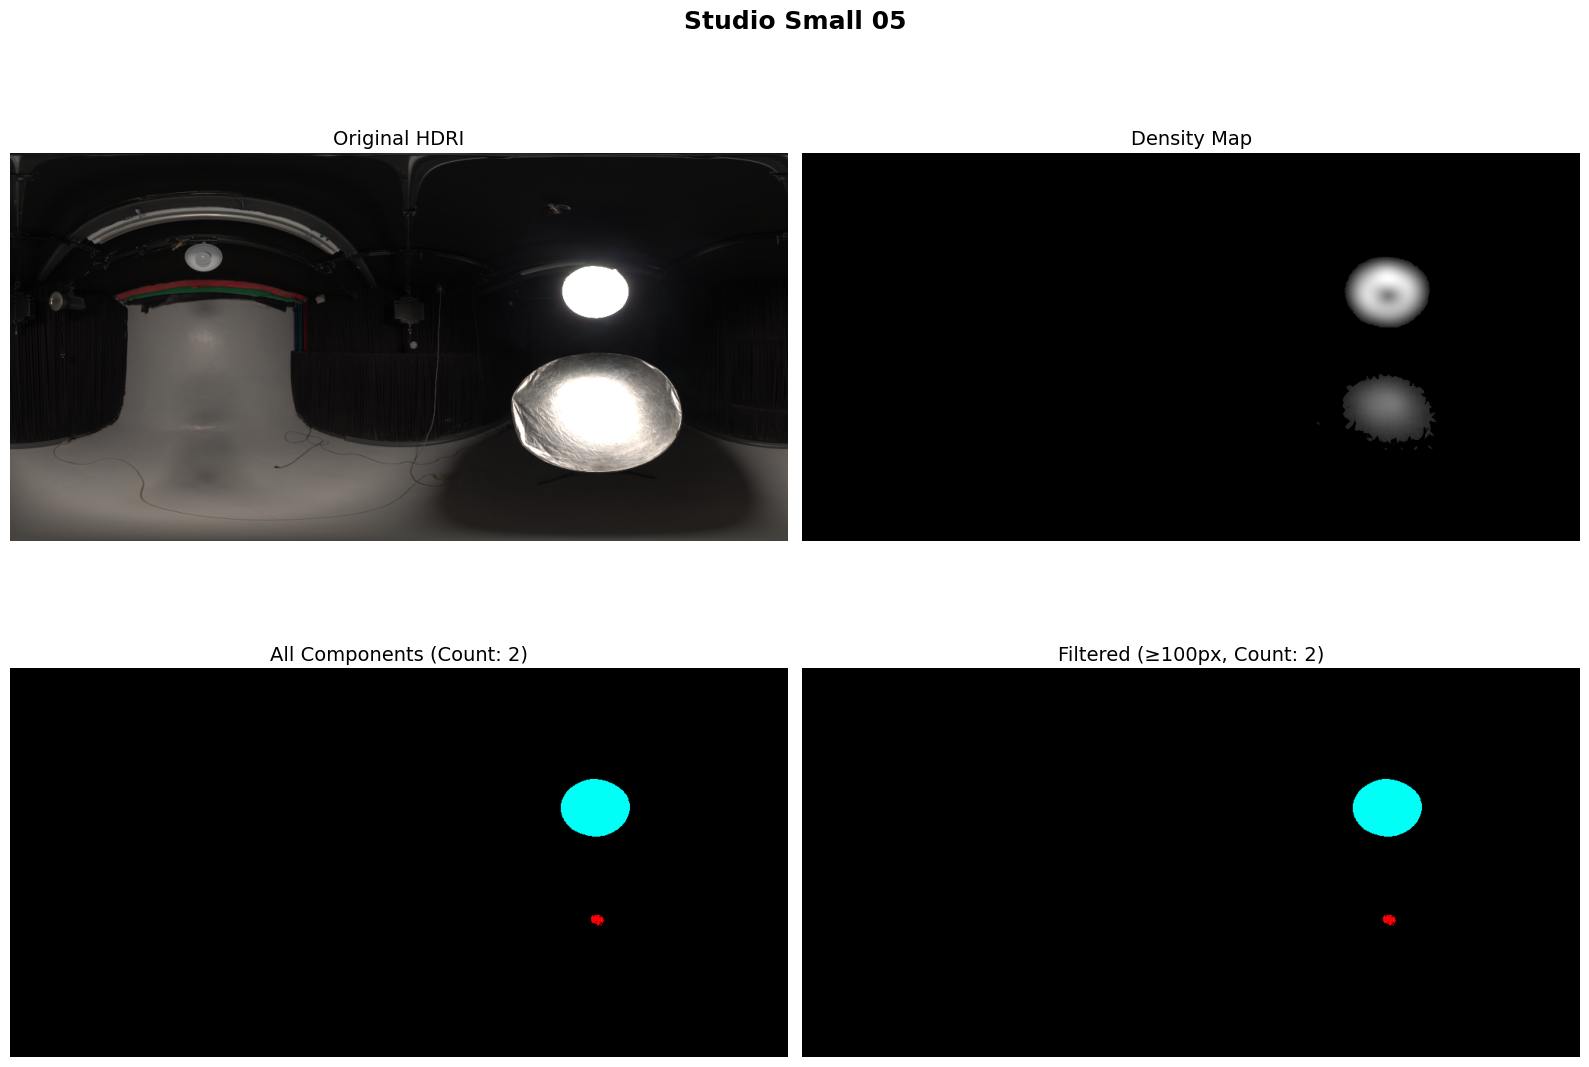

Studio Small 05:
  Original components (before wraparound merge): 2
  Components after wraparound merge: 2
  Filtered components: 2
  Components removed by filtering: 0



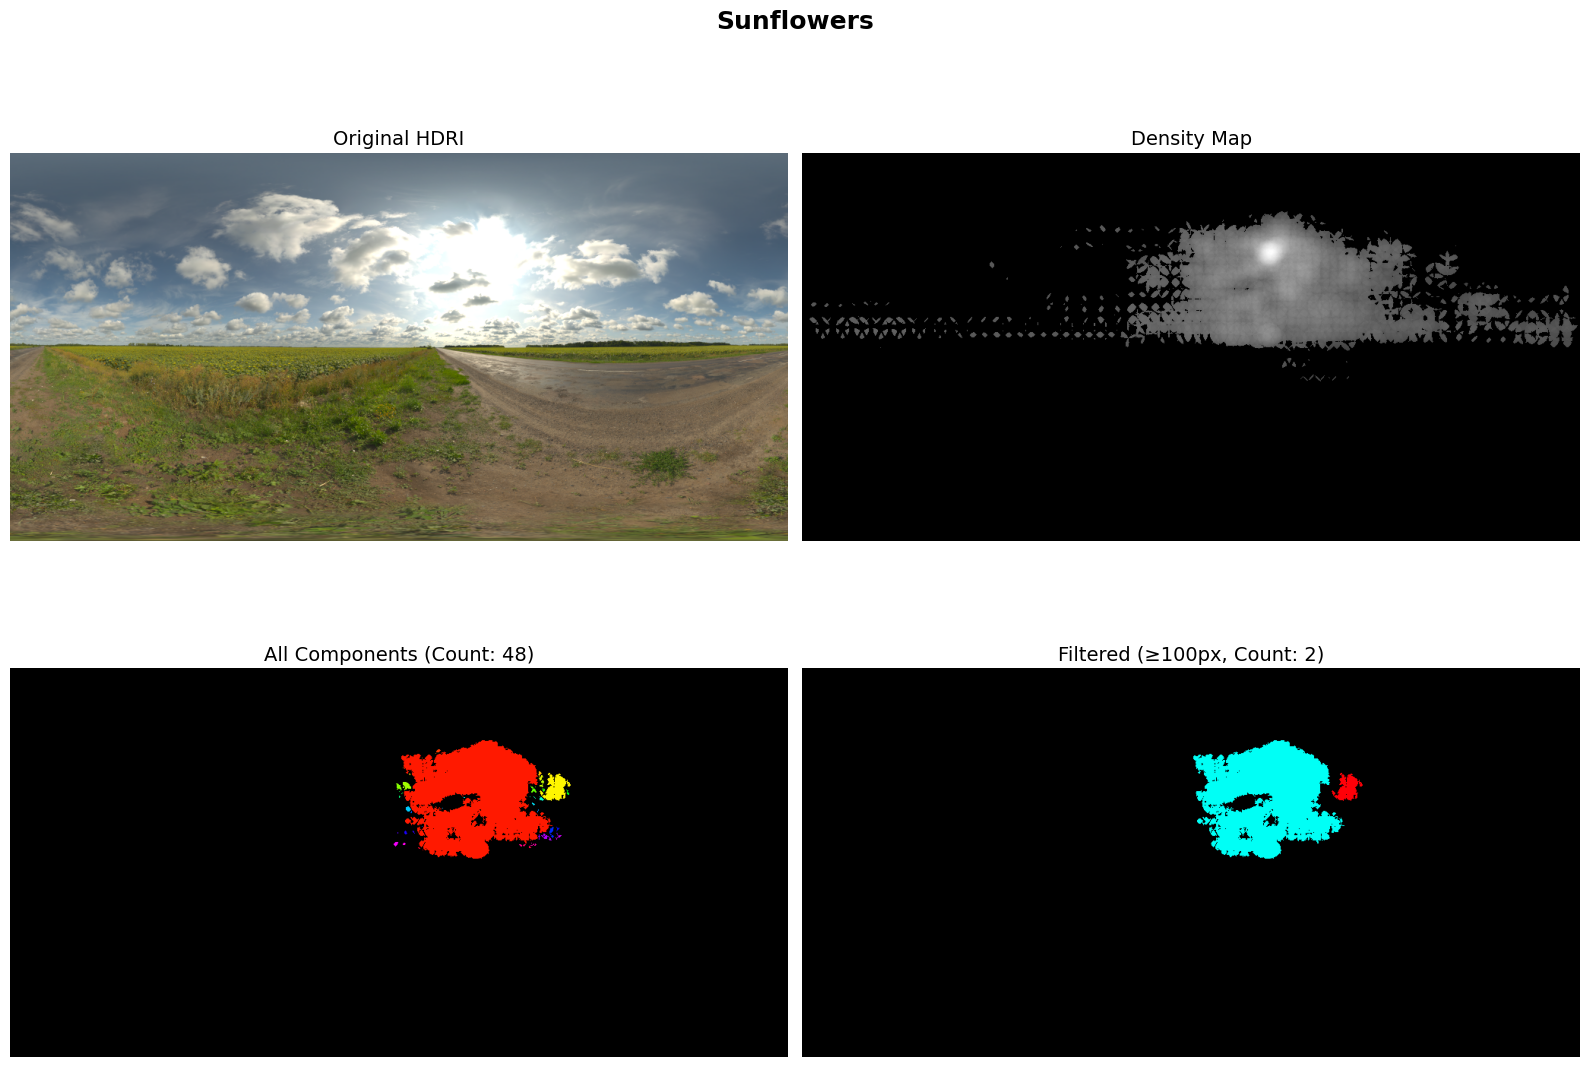

Sunflowers:
  Original components (before wraparound merge): 48
  Components after wraparound merge: 48
  Filtered components: 2
  Components removed by filtering: 46



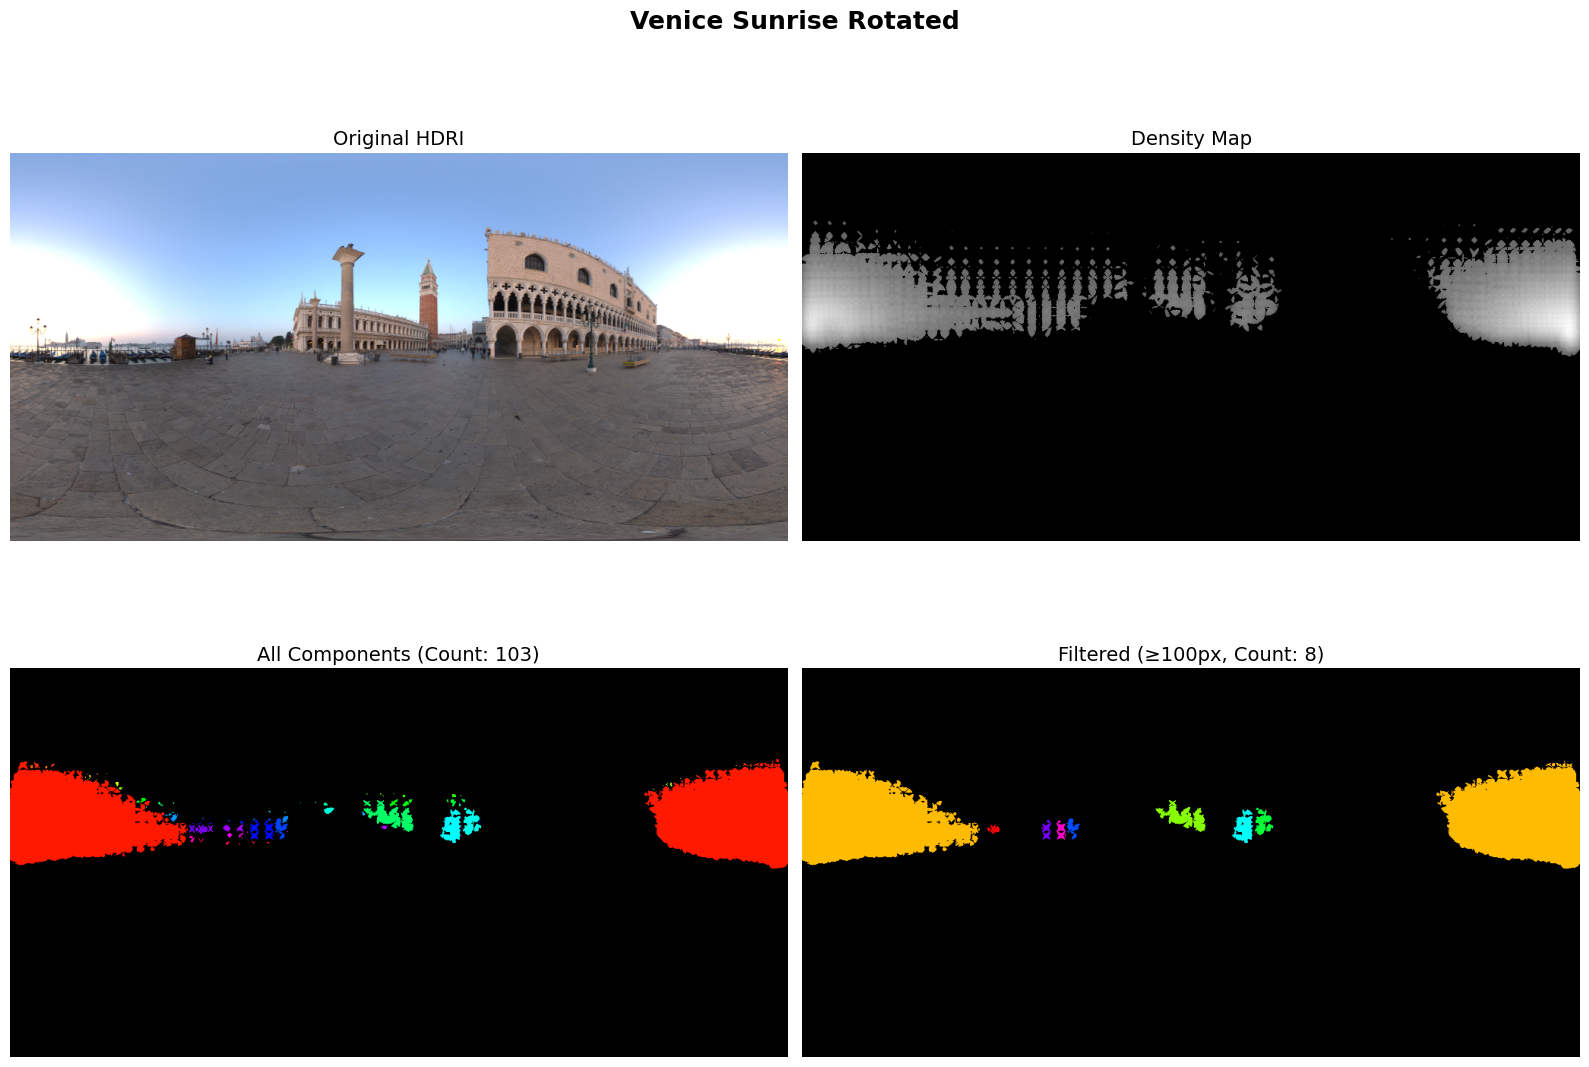

Venice Sunrise Rotated:
  Original components (before wraparound merge): 104
  Components after wraparound merge: 103
  Filtered components: 8
  Components removed by filtering: 95



In [38]:
# Process all HDRIs in the experiment
hdri_dirs = [d for d in experiment_dir.iterdir() if d.is_dir() and not d.name.endswith('_aggregate_statistics.html')]

print(f"Found {len(hdri_dirs)} HDRI directories to process:\\n")

# Loop through and process each HDRI
for hdri_dir in sorted(hdri_dirs):
    process_and_display_hdri(hdri_dir.name, hdri_dir)
